<a href="https://colab.research.google.com/github/R0N3ldrt/Thesis/blob/main/spectrum_v2-1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Enviroment

## Loading Drive and folders

In [3]:
# BLOQUE PARA USAR DESDE COLAB

# Google drive loading as work station for local-usage of the files.
from google.colab import drive
drive.mount('/content/gdrive',force_remount= True)

#-----------------------------------------------------------------------------

Mounted at /content/gdrive


In [4]:
# Lista para cambiar los paths rapido.
workers = ["Ronald", "Local"]

# Cambiar el numero aqui para cambiar los paths.
worker = workers[0]

if worker == "Ronald":
  path= "/content/gdrive/MyDrive/Thesis_Workstation/ANN_dataset"
else: path = os.getcwd()

## Loading Necesary Libraries

In [5]:
# Importing necesary libraries
import os, time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import pickle
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import r2_score
import seaborn as sn
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

# Loading Data

In [6]:
data_path=path+"/Spectrum"

qpsk_path="/QPSK/A.10hops100km/"
qam_path="/16QAM/A.10hops100km"

file_name="/dataSet_Spectrum_Samples_QPSK_37GHz_LongHaul_output_10x100.xlsx"
#file_name = "/QPSK_dummy.xlsx"
# Skipping first row since only contain "Frequency" headers
df_qpsk = pd.read_excel(data_path+qpsk_path+file_name, sheet_name = "Sheet1", skiprows=1)

#file_name="/dataSet_Spectrum_Samples_16QAM_75GHz_LongHaul_output_10x100.xlsx"
#file_name = "/16QAM_dummy.xlsx"
#df_qam = pd.read_excel(data_path+qam_path+file_name, sheet_name = "Sheet1", skiprows=1)

#Diff in column 5 to 1,286 0.03125

In [7]:
#dump_file = dict desireed to be saved
#filename = just the name of the file (file saved on "pickle_folder")

def pickle_out(dump_file, filename):
  filepath = path+"/pickle_folder/"+str(filename)+".pickle"
  pickleout = open(filepath, "wb")
  pickle.dump(dump_file, pickleout)
  pickleout.close()

def pickle_in(filename):
  filepath = path+"/pickle_folder/"+str(filename)+".pickle"
  picklein = open(filepath, "rb")
  loaded_dict = pickle.load(picklein)
  return loaded_dict

# Aggregator

In [8]:
def prime_number_finder(stop_gap, total_num_of_data):
  prime_nums = []
  i=2
  while i <= stop_gap:
    if (total_num_of_data % i==0):
      prime_nums.append(i)
    i+=1
  return prime_nums

In [9]:
def aggreagator_selection(stop_gap=25, total_num_of_data=1281, min_prime = False):
  current_freq_offset = 0.03125
  
  # Find the prime numbers where the total_num_of_data is divisible
  prime_nums = prime_number_finder(stop_gap, total_num_of_data)
  
  # Find the offsets of the new aggregators
  new_freq_offsets = []
  for nums in prime_nums:
    freq_offset = current_freq_offset*(nums-1)
    new_freq_offsets.append(freq_offset)

  # Select the prime number we would use to aggregation
  if min_prime == False:
    # Ask the user for the desired aggregator
    print('Please select one of the following prime number to conduct the aggregation {} with frequencies offsets of {}(PHz) respectively. (Current Freq offset is 0.03125 PHz)'.format(prime_nums, new_freq_offsets))
    while True:
      user_selection = input('Prime number to conduct the aggregation? ')
      if int(user_selection) not in prime_nums:
        print('Please select one of the available prime numbers. (Current selection is not avaliable)')
      else:
        break
    return int(user_selection)
  else:
    user_selection = min(prime_nums)
    freq_selected = min(new_freq_offsets)
    print('Selected the least common denominator for aggregation ({}) with a frequency of {}.'.format(user_selection, freq_selected))
    return int(user_selection)

In [10]:
def aggreagator(df, stop_gap=25, total_num_of_data=1281, min_prime = False):
  agg_num = aggreagator_selection(stop_gap, total_num_of_data, min_prime = min_prime)
  
  # Creating new df for aggregate values
  agg_df = pd.DataFrame()
  agg_df = df[df.columns[0:5]]

  agg=0
  loop_cnt=0
  init_column_cnt = 5
  while agg<=total_num_of_data:
    loop_cnt+=1
    # Obtain current last columns stop
    agg=agg_num+init_column_cnt
    # Select working columns
    new_df = df[df.columns[init_column_cnt:agg]]

    init_column_cnt += (agg_num)
    #print(init_column_cnt)
    # Get average of freq values for new header
    headers = list(new_df.columns.values)
    headers_array = np.asarray(headers)
    new_header_name = np.mean(headers_array)

    # Add aggragated values to new df
    agg_df[str(new_header_name)] = new_df.mean(axis = 1)
  agg_dict = agg_df.to_dict()
  return agg_df, agg_dict


In [11]:
# QPSK AGG
QPSK_agg_df, QPSK_agg_dict = aggreagator(df_qpsk, stop_gap=100, total_num_of_data=(df_qpsk.shape[1]-5), min_prime = True)
#pickle_out(QPSK_agg_dict, "test_agg_spectrum_QPSK_"+str(stop))

Selected the least common denominator for aggregation (3) with a frequency of 0.0625.


# Get model (Node and Power)

In [12]:
def get_dummy_spectrum(df, power):
  # Get selected power
  model_df = df[df['power_dBm'].isin([int(power)])]

  model_df = model_df.groupby(['#node', 'power_dBm']).mean()
  model_df.drop(['sampleid', 'Channels'], axis = 1, inplace = True)
  model_dict = model_df.to_dict()
  
  return model_df, model_dict
  #Return a tuple of (node, power) as keys in the nested dict and indexes

In [13]:
# Dummy Model QPSK
QPSK_dummy_df, QPSK_dummy_dict = get_dummy_spectrum(df_qpsk, power = -2)

#pickle_out(QPSK_dummy_dict, "dummy_AGG_spectrum_QPSK")

In [14]:
QPSK_dummy_df.head()

,,Distance_km,-20.0,-19.96875,-19.9375,-19.90625,-19.875,-19.84375,-19.8125,-19.78125,-19.75,...,19.71875,19.75,19.78125,19.8125,19.84375,19.875,19.90625,19.9375,19.96875,20.0
#node,power_dBm,,,,,,,,,,,,,,,,,,,,,
1.0,-2.0,0.0,-52.955056,-54.126681,-52.713840,-54.542630,-53.699036,-52.716651,-54.298754,-52.256947,-56.682823,...,-55.905776,-54.248709,-55.992318,-53.838975,-50.924380,-53.185248,-53.206559,-54.780695,-52.482275,-53.598605
2.0,-2.0,100.0,-51.813386,-53.194155,-52.697528,-52.418356,-52.486649,-50.289808,-54.422782,-54.110832,-55.149438,...,-53.005446,-55.507125,-54.494074,-50.651776,-54.789647,-53.624259,-51.423731,-55.126913,-57.266619,-51.729962
3.0,-2.0,200.0,-55.626777,-54.634329,-54.702958,-56.522545,-50.522361,-51.649987,-51.647787,-57.084303,-53.951639,...,-51.567208,-56.796925,-51.015703,-52.421725,-54.815529,-51.357553,-51.877358,-57.233009,-56.753557,-53.614796
4.0,-2.0,300.0,-56.824531,-53.690426,-50.972209,-54.176875,-54.362310,-54.521273,-55.501844,-53.146210,-53.794454,...,-55.812225,-51.239678,-55.243026,-51.354410,-55.306822,-52.059126,-54.439653,-52.965943,-50.612779,-53.485554
5.0,-2.0,400.0,-55.460110,-54.640315,-52.373595,-53.923790,-52.018852,-56.759420,-52.375980,-56.072875,-55.447448,...,-56.496858,-53.576828,-56.025184,-56.283557,-53.850835,-53.082112,-52.324651,-53.529109,-52.707990,-55.419718


# Get Data (Node and Power)

In [15]:
# available filters are -2, -1, 0

def get_data_spectrum(df, node, power):
  #data_df = pd.DataFrame({'#node': [int(node)], 'power_dBm': [int(power)]})
  # Get selected node
  data_df = df[df['#node'].isin([int(node)])]

  # Get selected power
  data_df = data_df[data_df['power_dBm'].isin([int(power)])]

  data_dict = data_df.to_dict()
  
  return data_df, data_dict
  #Return a tuple of (node, power) as keys in the nested dict and indexes

In [16]:
data_df, data_dict = get_data_spectrum(df_qpsk, node=1, power=-2)

In [17]:
data_df.head()

,sampleid,Channels,Distance_km,power_dBm,#node,-20.0,-19.96875,-19.9375,-19.90625,-19.875,...,19.71875,19.75,19.78125,19.8125,19.84375,19.875,19.90625,19.9375,19.96875,20.0
0,1.0,1.0,0.0,-2.0,1.0,-50.396272,-51.195507,-52.325501,-57.685476,-51.730270,...,-50.701297,-50.425586,-57.242411,-54.978886,-58.984450,-52.289897,-50.007652,-56.562352,-50.661037,-57.857937
1,2.0,1.0,0.0,-2.0,1.0,-49.464198,-62.300068,-49.878752,-45.576386,-50.935177,...,-52.919979,-61.894104,-60.851791,-53.621297,-47.427855,-57.669031,-51.735427,-56.145979,-51.259631,-46.965564
2,3.0,1.0,0.0,-2.0,1.0,-52.100342,-54.825356,-49.933739,-53.418630,-55.604328,...,-52.437768,-48.572056,-58.180955,-50.003337,-49.935404,-52.854423,-52.839831,-56.938673,-48.511327,-53.268586
3,4.0,1.0,0.0,-2.0,1.0,-61.429210,-54.973444,-45.026184,-63.731247,-45.706565,...,-56.792207,-59.099399,-45.632244,-56.454966,-46.126678,-50.632960,-48.675022,-50.899182,-64.439508,-46.552580
4,5.0,1.0,0.0,-2.0,1.0,-51.777530,-57.344578,-55.337847,-52.396041,-53.875442,...,-48.008932,-51.073828,-49.675923,-57.762095,-49.534186,-59.334809,-59.237640,-62.395677,-46.607586,-69.244091


# Remove outliers

## Sample outliears remove

In [18]:
def remove_outliers(df, row_index, lower_qr=25, upper_qr=75):

  # IQR
  Q1 = np.percentile(df.iloc[[row_index]], lower_qr, interpolation = 'midpoint')
  
  Q3 = np.percentile(df.iloc[[row_index]], upper_qr, interpolation = 'midpoint')
  IQR = Q3 - Q1
  
  # Above Upper bound
  upper = df.iloc[[row_index]] >= (Q3+1.5*IQR)
  upper_bound_drop_cols = np.where(upper)[1]
  
  # Below Lower bound
  lower = df.iloc[[row_index]] <= (Q1-1.5*IQR)
  lower_bound_drop_cols = np.where(lower)[1]
  
  
  drop_cols = np.concatenate((upper_bound_drop_cols, lower_bound_drop_cols), axis=None)

  new_df = df.drop(df.columns[drop_cols], axis=1)
  
  new_sample = new_df.iloc[[row_index]]
  return new_sample, drop_cols

In [19]:
df_qpsk_no_outliers, drop_cols = remove_outliers(data_df, row_index=0, lower_qr=15, upper_qr=85)

In [20]:
df_qpsk_no_outliers.shape

(1, 1286)

In [21]:
df_qpsk_no_outliers.head()

,sampleid,Channels,Distance_km,power_dBm,#node,-20.0,-19.96875,-19.9375,-19.90625,-19.875,...,19.71875,19.75,19.78125,19.8125,19.84375,19.875,19.90625,19.9375,19.96875,20.0
0,1.0,1.0,0.0,-2.0,1.0,-50.396272,-51.195507,-52.325501,-57.685476,-51.73027,...,-50.701297,-50.425586,-57.242411,-54.978886,-58.98445,-52.289897,-50.007652,-56.562352,-50.661037,-57.857937


## Model match new sample df

In [22]:
def model_match_sample(model_df, sample_drop_cols):

  new_drop_cols = []
  for col in sample_drop_cols:
    new_drop_cols.append(int(col-4))

  new_model_df = model_df.drop(model_df.columns[new_drop_cols], axis=1)
  return new_model_df

In [23]:
QPSK_dummy_df_no_outliers = model_match_sample(QPSK_dummy_df, drop_cols)

In [24]:
display(QPSK_dummy_df_no_outliers)

,,Distance_km,-20.0,-19.96875,-19.9375,-19.90625,-19.875,-19.84375,-19.8125,-19.78125,-19.75,...,19.71875,19.75,19.78125,19.8125,19.84375,19.875,19.90625,19.9375,19.96875,20.0
#node,power_dBm,,,,,,,,,,,,,,,,,,,,,
1.0,-2.0,0.0,-52.955056,-54.126681,-52.713840,-54.542630,-53.699036,-52.716651,-54.298754,-52.256947,-56.682823,...,-55.905776,-54.248709,-55.992318,-53.838975,-50.924380,-53.185248,-53.206559,-54.780695,-52.482275,-53.598605
2.0,-2.0,100.0,-51.813386,-53.194155,-52.697528,-52.418356,-52.486649,-50.289808,-54.422782,-54.110832,-55.149438,...,-53.005446,-55.507125,-54.494074,-50.651776,-54.789647,-53.624259,-51.423731,-55.126913,-57.266619,-51.729962
3.0,-2.0,200.0,-55.626777,-54.634329,-54.702958,-56.522545,-50.522361,-51.649987,-51.647787,-57.084303,-53.951639,...,-51.567208,-56.796925,-51.015703,-52.421725,-54.815529,-51.357553,-51.877358,-57.233009,-56.753557,-53.614796
4.0,-2.0,300.0,-56.824531,-53.690426,-50.972209,-54.176875,-54.362310,-54.521273,-55.501844,-53.146210,-53.794454,...,-55.812225,-51.239678,-55.243026,-51.354410,-55.306822,-52.059126,-54.439653,-52.965943,-50.612779,-53.485554
5.0,-2.0,400.0,-55.460110,-54.640315,-52.373595,-53.923790,-52.018852,-56.759420,-52.375980,-56.072875,-55.447448,...,-56.496858,-53.576828,-56.025184,-56.283557,-53.850835,-53.082112,-52.324651,-53.529109,-52.707990,-55.419718
6.0,-2.0,500.0,-53.388700,-54.150105,-55.930677,-54.575055,-55.206565,-56.648453,-53.750916,-55.094424,-54.633145,...,-57.890154,-54.812914,-57.667351,-53.486017,-54.388727,-53.904756,-54.918162,-54.537147,-57.624945,-56.669234
7.0,-2.0,600.0,-56.253249,-54.806230,-57.513050,-54.182125,-53.953778,-55.617854,-54.371333,-54.109618,-53.999682,...,-53.744885,-55.905212,-52.997440,-54.208713,-54.392674,-56.379966,-54.650810,-53.664828,-52.381690,-53.821635
8.0,-2.0,700.0,-54.043509,-58.115489,-53.273335,-56.809345,-53.114463,-56.279279,-56.366876,-58.487124,-52.937670,...,-56.587696,-54.675434,-55.494814,-57.098256,-56.788089,-53.384522,-56.223255,-54.754464,-57.149606,-57.138661
9.0,-2.0,800.0,-54.113033,-56.330593,-52.985305,-52.133244,-52.518393,-54.634498,-54.235772,-62.339601,-54.209660,...,-55.443576,-54.620808,-53.784036,-54.209671,-54.633816,-56.942391,-55.301259,-56.763001,-56.245734,-55.416871


In [25]:
def match_model_with_sample(model_df):
  model_df.insert(loc = 0, column = 'sampleid', value = 1)
  model_df.insert(loc = 1, column = 'Channels', value = 1)
  model_df.insert(loc = 3, column = 'power_dBm', value = 0)
  model_df.insert(loc = 4, column = '#node', value = 0)  
  
  row = 0
  for idx in model_df.index:
    model_df.iloc[row, [3]] = idx[1]
    model_df.iloc[row, [4]] = idx[0]
    row += 1

  return model_df

In [26]:
match_QPSK_dummy_df_no_outliers = match_model_with_sample(QPSK_dummy_df_no_outliers)

In [27]:
display(match_QPSK_dummy_df_no_outliers)

,,sampleid,Channels,Distance_km,power_dBm,#node,-20.0,-19.96875,-19.9375,-19.90625,-19.875,...,19.71875,19.75,19.78125,19.8125,19.84375,19.875,19.90625,19.9375,19.96875,20.0
#node,power_dBm,,,,,,,,,,,,,,,,,,,,,
1.0,-2.0,1,1,0.0,-2,1,-52.955056,-54.126681,-52.713840,-54.542630,-53.699036,...,-55.905776,-54.248709,-55.992318,-53.838975,-50.924380,-53.185248,-53.206559,-54.780695,-52.482275,-53.598605
2.0,-2.0,1,1,100.0,-2,2,-51.813386,-53.194155,-52.697528,-52.418356,-52.486649,...,-53.005446,-55.507125,-54.494074,-50.651776,-54.789647,-53.624259,-51.423731,-55.126913,-57.266619,-51.729962
3.0,-2.0,1,1,200.0,-2,3,-55.626777,-54.634329,-54.702958,-56.522545,-50.522361,...,-51.567208,-56.796925,-51.015703,-52.421725,-54.815529,-51.357553,-51.877358,-57.233009,-56.753557,-53.614796
4.0,-2.0,1,1,300.0,-2,4,-56.824531,-53.690426,-50.972209,-54.176875,-54.362310,...,-55.812225,-51.239678,-55.243026,-51.354410,-55.306822,-52.059126,-54.439653,-52.965943,-50.612779,-53.485554
5.0,-2.0,1,1,400.0,-2,5,-55.460110,-54.640315,-52.373595,-53.923790,-52.018852,...,-56.496858,-53.576828,-56.025184,-56.283557,-53.850835,-53.082112,-52.324651,-53.529109,-52.707990,-55.419718
6.0,-2.0,1,1,500.0,-2,6,-53.388700,-54.150105,-55.930677,-54.575055,-55.206565,...,-57.890154,-54.812914,-57.667351,-53.486017,-54.388727,-53.904756,-54.918162,-54.537147,-57.624945,-56.669234
7.0,-2.0,1,1,600.0,-2,7,-56.253249,-54.806230,-57.513050,-54.182125,-53.953778,...,-53.744885,-55.905212,-52.997440,-54.208713,-54.392674,-56.379966,-54.650810,-53.664828,-52.381690,-53.821635
8.0,-2.0,1,1,700.0,-2,8,-54.043509,-58.115489,-53.273335,-56.809345,-53.114463,...,-56.587696,-54.675434,-55.494814,-57.098256,-56.788089,-53.384522,-56.223255,-54.754464,-57.149606,-57.138661
9.0,-2.0,1,1,800.0,-2,9,-54.113033,-56.330593,-52.985305,-52.133244,-52.518393,...,-55.443576,-54.620808,-53.784036,-54.209671,-54.633816,-56.942391,-55.301259,-56.763001,-56.245734,-55.416871


In [28]:
print(data_df.shape)
print(df_qpsk_no_outliers.shape)
print(QPSK_dummy_df.shape)
print(QPSK_dummy_df_no_outliers.shape)
print(match_QPSK_dummy_df_no_outliers.shape)

(10, 1286)
(1, 1286)
(11, 1282)
(11, 1286)
(11, 1286)


# Separate tails

In [29]:
def tails_generator(row_df):
  total_columns = row_df.shape[1]-5
  mid_point = int(total_columns/2)

  new_sample = row_df.iloc[:, 0:5]
  mid_point = mid_point+5

  left_tail = row_df.iloc[:, 5:mid_point]
  rigth_tail = row_df.iloc[:, mid_point+1:row_df.shape[1]]

  return left_tail, rigth_tail


In [30]:
sample_left_tail, sample_rigth_tail = tails_generator(df_qpsk_no_outliers)
model_left_tail, model_rigth_tail = tails_generator(match_QPSK_dummy_df_no_outliers)

In [31]:
print(sample_left_tail.shape)
print(sample_rigth_tail.shape)

print(model_left_tail.shape)
print(model_rigth_tail.shape)

(1, 640)
(1, 640)
(11, 640)
(11, 640)


In [32]:
display(model_left_tail)

,,-20.00000,-19.96875,-19.93750,-19.90625,-19.87500,-19.84375,-19.81250,-19.78125,-19.75000,-19.71875,...,-0.31250,-0.28125,-0.25000,-0.21875,-0.18750,-0.15625,-0.12500,-0.09375,-0.06250,-0.03125
#node,power_dBm,,,,,,,,,,,,,,,,,,,,,
1.0,-2.0,-52.955056,-54.126681,-52.713840,-54.542630,-53.699036,-52.716651,-54.298754,-52.256947,-56.682823,-52.906297,...,-10.335407,-10.446735,-12.961742,-9.150952,-9.183307,-11.044555,-13.704031,-11.839053,-13.695669,-12.419929
2.0,-2.0,-51.813386,-53.194155,-52.697528,-52.418356,-52.486649,-50.289808,-54.422782,-54.110832,-55.149438,-55.181164,...,-10.412752,-10.487917,-12.996865,-9.209824,-9.176572,-10.935723,-13.603429,-11.823596,-13.763764,-12.475263
3.0,-2.0,-55.626777,-54.634329,-54.702958,-56.522545,-50.522361,-51.649987,-51.647787,-57.084303,-53.951639,-53.765878,...,-10.493401,-10.694883,-13.179642,-9.274942,-9.270857,-10.880847,-13.668511,-11.835387,-13.589056,-12.448698
4.0,-2.0,-56.824531,-53.690426,-50.972209,-54.176875,-54.362310,-54.521273,-55.501844,-53.146210,-53.794454,-54.751432,...,-10.477138,-10.725330,-12.946959,-9.265135,-9.311574,-11.069437,-13.660623,-11.804706,-13.537532,-12.403333
5.0,-2.0,-55.460110,-54.640315,-52.373595,-53.923790,-52.018852,-56.759420,-52.375980,-56.072875,-55.447448,-55.084601,...,-10.691072,-11.053235,-13.140224,-9.373044,-9.503218,-11.526951,-13.555084,-11.976089,-13.457985,-12.390386
6.0,-2.0,-53.388700,-54.150105,-55.930677,-54.575055,-55.206565,-56.648453,-53.750916,-55.094424,-54.633145,-52.734627,...,-10.917511,-11.222398,-13.127098,-9.348403,-9.529615,-11.778032,-13.654027,-11.995124,-13.421449,-12.497542
7.0,-2.0,-56.253249,-54.806230,-57.513050,-54.182125,-53.953778,-55.617854,-54.371333,-54.109618,-53.999682,-56.058418,...,-11.161671,-11.409546,-13.123292,-9.375071,-9.494967,-11.768465,-13.687554,-12.065882,-13.260818,-12.739931
8.0,-2.0,-54.043509,-58.115489,-53.273335,-56.809345,-53.114463,-56.279279,-56.366876,-58.487124,-52.937670,-57.056037,...,-11.363844,-11.510741,-13.445608,-9.589123,-9.618038,-11.799159,-13.752264,-12.133780,-13.279974,-12.793737
9.0,-2.0,-54.113033,-56.330593,-52.985305,-52.133244,-52.518393,-54.634498,-54.235772,-62.339601,-54.209660,-57.682738,...,-11.984936,-11.733312,-13.603808,-9.634031,-9.837673,-11.431543,-13.672051,-12.202841,-13.365502,-12.792715


# Linear Regresion (Calculate R^2)

In [33]:
def linear_regression(sample_tail, model_tail, model_eval_node):
  
  model_eval_node = model_eval_node-1
  model_tail = model_tail.iloc[model_eval_node].to_numpy()

  y = np.array(model_tail)

  sample_tail = sample_tail.iloc[[0]].to_numpy()
  x = np.array(sample_tail).reshape((-1, 1))

  # Get linear regresion features
  model = LinearRegression()
  model.fit(x, y)
  model = LinearRegression().fit(x, y)
  r_sqr = model.score(x, y)

  return r_sqr

# intercept = model.intercept_
# slope = model.coef_

In [34]:
left_r_sqr = linear_regression(sample_left_tail, model_left_tail, model_eval_node = 1)

In [35]:
rigth_r_sqr = linear_regression(sample_rigth_tail, model_rigth_tail, model_eval_node = 1)

# Confusion Matrix

In [45]:
def confusion_matrix(y_actual, y_pred, filepath_to_save, power):
  # Setting the figure size
  fig = plt.figure(figsize=(7,5))

  data = {'y_Actual':    y_actual,
          'y_Predicted': y_pred}

  df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
  confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

  sn.heatmap(confusion_matrix, annot=True, cbar=False, cmap='Blues')

  # Give a title to the graph
  plt.title('Confusion Matrix Nodes Samples with Power '+ str(power)) 

  #Saving the plot as an image
  fig.savefig(filepath_to_save, bbox_inches='tight', dpi=150)
  plt.show()

# Classifier

In [58]:
def classifier(eval_df, model_df, filepath_confusion_m, aggregate = False, aggregate_min_prime = False, lower_qr  = 15, upper_qr = 85):
  true_storage = {}
  predit_storage = {}

  # obtain the distances available in eval_df
  distances = []
  for distance_val in eval_df['Distance_km'].unique():
    distances.append(distance_val)

  # Select model data that only contain the distances available in the sample file
  model_df = model_df.loc[model_df['Distance_km'].isin(distances)]
  
  # Loop each power available
  for power_row in eval_df['power_dBm'].unique():
  
    y_actual = np.array([])
    y_predit = np.array([])
    print('--- Evaluating Power {} ---'.format(power_row))
    # ---------------- This should be modified once we have the real model dataset ----------------
    model_dummy_df, model_dummy_dict = get_dummy_spectrum(model_df, power = power_row)

    # Conduct aggregation if requested
    if aggregate == True:
      eval_df, eval_agg_dict = aggreagator(eval_df, stop_gap=100, total_num_of_data=(eval_df.shape[1]-5), min_prime = aggregate_min_prime)
      model_dummy_df, model_agg_dict = aggreagator(model_dummy_df, stop_gap=100, total_num_of_data=(model_dummy_df.shape[1]-5), min_prime = aggregate_min_prime)

    # Loop each distance available
    for node_row in eval_df['#node'].unique():
      data_df, data_dict = get_data_spectrum(eval_df, node = node_row, power = power_row)

      #Actual values
      y_actual_node = data_df['#node'].to_numpy()

      # Loop each sample row
      for row in range(data_df.shape[0]):
        # Remove outliers from sample data
        df_data_no_outliers, drop_cols = remove_outliers(data_df, row_index = row, lower_qr = lower_qr, upper_qr = upper_qr)

        # Match model data with new sample data after outliers removed
        model_dummy_df_no_outliers = model_match_sample(model_dummy_df, drop_cols)
        match_model_dummy_df_no_outliers = match_model_with_sample(model_dummy_df_no_outliers)

        # Obtain tails of sample and model data
        sample_left_tail, sample_rigth_tail = tails_generator(df_data_no_outliers)
        model_left_tail, model_rigth_tail = tails_generator(match_model_dummy_df_no_outliers)

        r_sqr_storage = []
        # Loop through each model node available
        for model_row in range(match_model_dummy_df_no_outliers.shape[0]):
          
          # Calculate R_sqr between sample and model
          left_r_sqr = linear_regression(sample_left_tail, model_left_tail, model_eval_node = (model_row+1))
          rigth_r_sqr = linear_regression(sample_rigth_tail, model_rigth_tail, model_eval_node = (model_row+1))
          mean_r_sqr  = (left_r_sqr+rigth_r_sqr)/2
          r_sqr_storage.append(mean_r_sqr)
        
        # Select the highest r_sqr position (Predicted Node)
        maxval = np.amax(r_sqr_storage)
        indice = np.where(r_sqr_storage == np.amax(r_sqr_storage))
        pos_max = indice[0][0]+1    

        #y_predit.append(pos_max)
        y_predit = np.append(y_predit, pos_max)
      y_actual = np.concatenate((y_actual, y_actual_node), axis=0)
    
    y_predit = y_predit.astype(int)
    y_actual = y_actual.astype(int)
    
    true_storage['Power_'+str(power_row)] = y_actual
    predit_storage['Power_'+str(power_row)] = y_predit

    # Confusion matrix
    filepath_m = filepath_confusion_m +'Power_'+ str(power_row) +'.jpg'

    confusion_matrix(y_actual, y_predit, filepath_m, power=power_row)

    print('F1 score {}'.format(f1_score(y_actual, y_predit, average='weighted')))

  return y_actual, y_predit, true_storage, predit_storage

--- Evaluating Power -2.0 ---


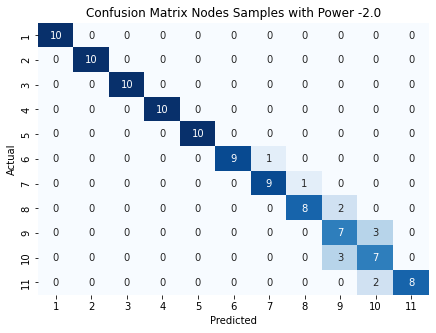

F1 score 0.8955536223478806
--- Evaluating Power -1.0 ---


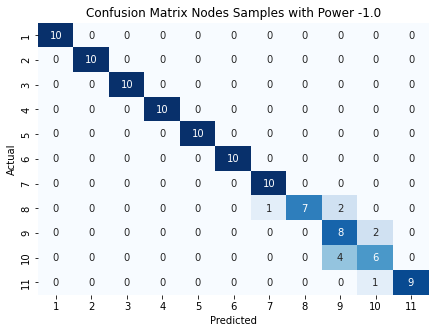

F1 score 0.9110476726575798
--- Evaluating Power 0.0 ---


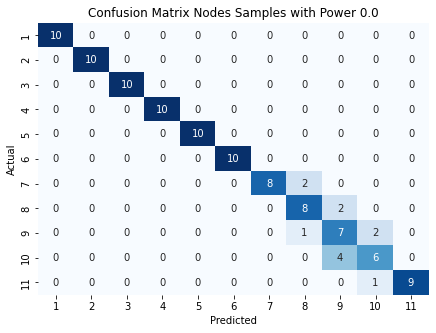

F1 score 0.8944033337626014


In [59]:
save_confusion_filepath = path + '/plots/spectrum/10hops100km_confusion_matrix_'
y_actual, y_predit, true_storage, predit_storage = classifier(df_qpsk, df_qpsk, filepath_confusion_m = save_confusion_filepath, aggregate = False, aggregate_min_prime = False, lower_qr  = 15, upper_qr = 85)

In [60]:
print(true_storage)

print(predit_storage)

{'Power_-2.0': array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 11, 11, 11, 11]), 'Power_-1.0': array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,  4,  4,
        4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11,
       11, 11, 11, 11, 11, 11,

# Test additional scenarios

In [61]:
qpsk_data_path=path+"/Spectrum/QPSK"

qam_data_path=path+"/Spectrum/16QAM"

# Test files

# QPSK files
files_to_evaluate_qpsk = []
for subdir, dirs, files in os.walk(qpsk_data_path):
    for file in files:
        if "dataSet_Spectrum_Samples_QPSK_37GHz_LongHaul_output_" in file:
          files_to_evaluate_qpsk.append(os.path.join(subdir, file))

# QAM files
files_to_evaluate_qam = []
for subdir, dirs, files in os.walk(qam_data_path):
    for file in files:
        if "dataSet_Spectrum_Samples_16QAM_75GHz_LongHaul_output_" in file:
          files_to_evaluate_qam.append(os.path.join(subdir, file))

# Model files
qpsk_model = qpsk_data_path + '/A.10hops100km/dataSet_Spectrum_Samples_QPSK_37GHz_LongHaul_output_10x100.xlsx'
qam_model = qam_data_path + '/A.10hops100km/dataSet_Spectrum_Samples_16QAM_75GHz_LongHaul_output_10x100.xlsx'

--- Evaluating dataSet_Spectrum_Samples_QPSK_37GHz_LongHaul_output_4x250 ---
--- Evaluating Power -2 ---


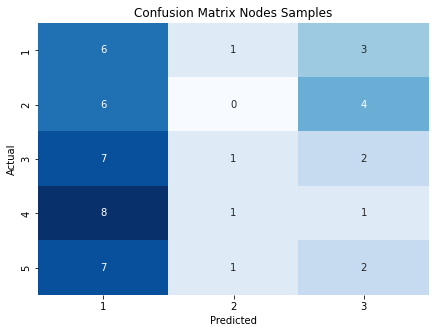

--- Evaluating Power -1 ---


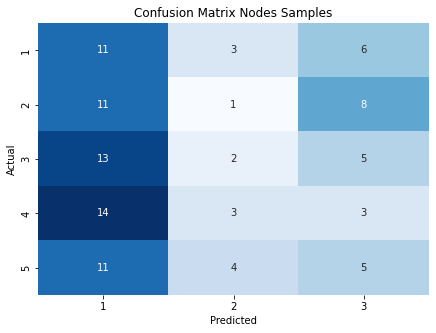

--- Evaluating Power 0 ---


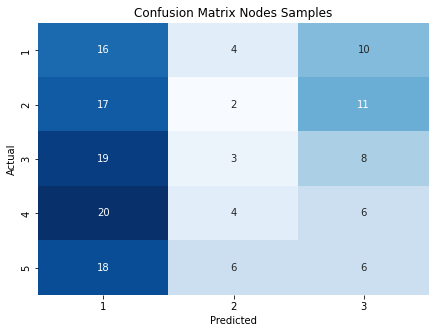

F1 score 0.11473028648078952


In [293]:
# Model df
df_model = pd.read_excel(qpsk_model, sheet_name = "Sheet1", skiprows=1)
for file_x in files_to_evaluate_qpsk:
  print('--- Evaluating {} ---'.format(file_x[file_x.find('dataSet') : file_x.find('.xlsx')]))
  
  # Confusion Matrix filepath
  confusion_m_filename = (file_x[file_x.find('Samples') : file_x.find('.xlsx')])+'_Confusion_Matrix.jpg'
  save_confusion_filepath = path + '/plots/spectrum/'+confusion_m_filename
  # Samples df
  # Skipping first row since only contain "Frequency" headers
  df_qpsk = pd.read_excel(file_x, sheet_name = "Sheet1", skiprows=1)
  
  # Run classifier
  y_actual, y_predit, true_storage, predit_storage = classifier(df_qpsk, df_model, filepath_confusion_m = save_confusion_filepath, aggregate = False, aggregate_min_prime = False, lower_qr  = 15, upper_qr = 85)

  break

In [1]:
print(y_actual)
print(y_predit)

NameError: ignored